In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import matplotlib
import os

from utils import load_poc_database, get_combined_df

In [2]:
print(sns.__version__)

0.10.1


In [3]:
lon = {'Californian':[-155,-95], 'Peruvian':[-115,-55], 'Namibian':[-25,35]}
lat = {'Californian':[5,55], 'Peruvian':[-45,5], 'Namibian':[-45,15]}
name_convert = {'Peru':'Peruvian', 'California':'Californian', 'Namibia':'Namibian'}

to_plot = ['Cloud_Effective_Radius', 'Cloud_Water_Path', 'Cloud_Optical_Thickness']
# to_plot_5km = ['Surface_Pressure', 'Cloud_Top_Height', 'Cloud_Fraction', 'Tropopause_Height', 'Surface_Temperature']
# to_plot_5km = ['Cloud_Top_Height', 'Cloud_Fraction', 'Surface_Temperature']

formatted_names = {'Cloud_Effective_Radius':'Cloud Effective Radius ($\mu$m)', 'Cloud_Water_Path':'Cloud Water Path (g/m^2)', 
                   'Cloud_Optical_Thickness':'Cloud Optical Thickness (1)', 'Surface_Pressure':'Surface Pressure (hPa)', 
                   'Cloud_Top_Height':'Cloud Top Height (m)', 'Cloud_Fraction':'Cloud Fraction (1)', 
                   'Tropopause_Height':'Tropopause Height (hPa)', 'Surface_Temperature':'Surface Temperature (K)',
                   'lwp': 'Liquid Water Path (kg/m^2)', 'rain_prob': "Probability of Rain (1)", "rain_rwr": "rain_rwr"}

In [4]:
poc_data = load_poc_database('F:\\Local Data/POCs/POC_database_2.dat')

In [5]:
df_all_aqua_unmasked = get_combined_df('C://Users//duncan/Desktop//results_all_all_data_all_regions_width15.pickle', stripe_width=15)
df_all_aqua_masked = get_combined_df('C://Users//duncan/Desktop//results_all_masked_data_all_regions_width5.pickle', stripe_width=5)
df_terra = get_combined_df('C://Users//duncan/Desktop//results_1km.pickle', stripe_width=15, cloudsat=False, AMSR=False)

In [6]:
# Convert from Kg to g
df_all_aqua_masked.lwp = df_all_aqua_masked.lwp * 1000. 
df_all_aqua_unmasked.lwp = df_all_aqua_unmasked.lwp * 1000. 

In [7]:
df_all_aqua_unmasked_low_cloud = df_all_aqua_unmasked[(df_all_aqua_unmasked.cloudsat_cth1l < 2.)]
df_all_aqua_masked_low_cloud = df_all_aqua_masked[(df_all_aqua_masked.cloudsat_cth1l < 2.)]

In [8]:
df_all_aqua_masked_low_cloud.groupby("Unnamed: 0").poc_mask.sum().describe()
# 398 CloudSat POCs

count     398.000000
mean      646.878368
std       725.339396
min         0.000000
25%         1.775653
50%       296.887424
75%      1080.880760
max      3050.725938
Name: poc_mask, dtype: float64

In [9]:
df_all_aqua_masked.groupby("Unnamed: 0").poc_mask.mean().describe()
# 1572 Aqua (AMSR) POCs

count    1572.000000
mean       80.299721
std        30.947515
min         0.000000
25%        60.242428
50%        84.907015
75%       104.790199
max       132.467673
Name: poc_mask, dtype: float64

8


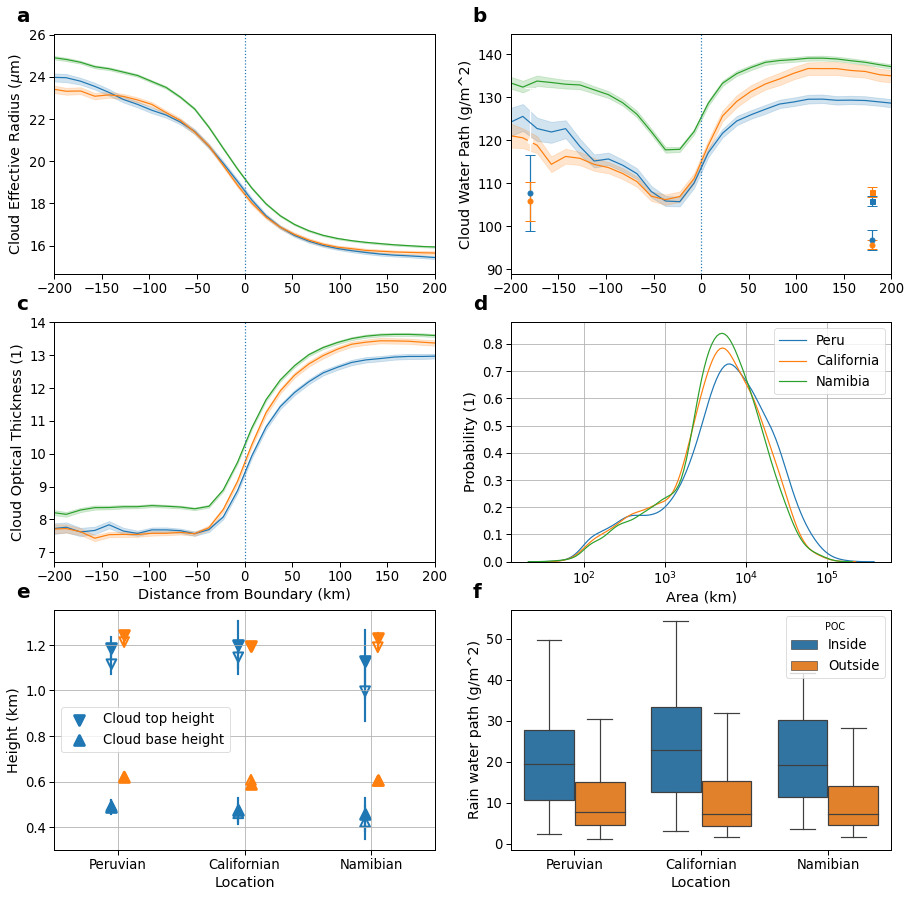

In [11]:
no_variables=len(to_plot) + 3

sns.set_context('paper', font_scale=1.5)

index = 0
fig, ax = plt.subplots(math.floor(no_variables/2), 2, figsize = (15, 5*math.floor(no_variables/2)))

for variable in to_plot:
    current_ax=ax[math.floor(index/2),index%2]
    sns.lineplot(x='Distance from Boundary (km)', y=variable, data=df_terra, hue='Location', ax=current_ax, ci=68)
    current_ax.axvline(x=0, linestyle=':')
    current_ax.set_xlabel('')
    current_ax.set_ylabel(formatted_names[variable])
    current_ax.set_xlim(-200,200)
    handles, labels = current_ax.get_legend_handles_labels()
    current_ax.get_legend().remove()
    index += 1
    
ax[1,0].set_xlabel('Distance from Boundary (km)')

# I probably don't want these any more
# Add adiabatic lines
# def get_adiabatic_lwp(df):
#     thickness = df.cloudsat_cth1l-df.cloudsat_cbh1l
#     return 0.5* 2.332 * (thickness.mean()**2) / 6

# for handle, (r, r_df) in zip(handles, df.groupby('Location')):
#     inside_lwp = get_adiabatic_lwp(r_df[r_df.POC=='Inside'])
#     outside_lwp = get_adiabatic_lwp(r_df[r_df.POC=='Outside'])
#     ax[0,1].plot([-75, 0], [inside_lwp, inside_lwp], c=handle.get_color())
#     ax[0,1].plot([0, 100], [outside_lwp, outside_lwp], c=handle.get_color())


lwp_ax = ax[0,1]
for handle, (r, r_df) in zip(handles, df_all_aqua_masked_low_cloud.groupby('Location')):
    mean_poc = r_df.groupby('POC').mean()
    std_err_poc =r_df.groupby('POC').sem()
    std_poc =r_df.groupby('POC').std()
    
    lwp_ax.errorbar([-180], [mean_poc.cloudsat_lwp['Inside']], yerr=[std_err_poc.cloudsat_lwp['Inside']], capsize=5, fmt='o', c=handle.get_color(), markersize=5)
    lwp_ax.errorbar([180], [mean_poc.cloudsat_lwp['Outside']], yerr=[std_err_poc.cloudsat_lwp['Outside']], capsize=5, fmt='o', c=handle.get_color(), markersize=5)
    lwp_ax.errorbar([180], [mean_poc.lwp['Outside']], yerr=[std_err_poc.lwp['Outside']], capsize=5, fmt='s', c=handle.get_color(), markersize=5)
    

# Plot the cloudsat rain
cloudsat_ax = ax[2,1]
sns.boxplot(x="Location", y="cloudsat_rwp", data=df_all_aqua_unmasked_low_cloud, hue='POC', showfliers=False, hue_order=['Inside', 'Outside'], ax=cloudsat_ax)
cloudsat_ax.set_ylabel("Rain water path (g/m^2)")

    
# Plot the cloudsat distributions
cloudsat_ax = ax[2,0]
sns.pointplot(x="Location", y="cloudsat_cth1l", hue="POC",
            markers=["v", "v"], linestyles=["", ""], hue_order=['Inside', 'Outside'], order=['Peruvian', 'Californian', 'Namibian'],
            data=df_all_aqua_masked_low_cloud, dodge=.1, ax=cloudsat_ax, scale=1.8)
sns.pointplot(x="Location", y="cloudsat_cbh1l", hue="POC",
            markers=["^", "^"], linestyles=["", ""], hue_order=['Inside', 'Outside'], order=['Peruvian', 'Californian', 'Namibian'],
            data=df_all_aqua_masked_low_cloud, dodge=.1, ax=cloudsat_ax, scale=1.8)

# Plot the unmasked points too
sns.pointplot(x="Location", y="cloudsat_cth1l", hue="POC",
            markers=["v", "v"], linestyles=["", ""], hue_order=['Inside', 'Outside'], order=['Peruvian', 'Californian', 'Namibian'],
            data=df_all_aqua_unmasked_low_cloud, dodge=.1, ax=cloudsat_ax, scale=1.8)
p=sns.pointplot(x="Location", y="cloudsat_cbh1l", hue="POC",
            markers=["^", "^"], linestyles=["", ""], hue_order=['Inside', 'Outside'], order=['Peruvian', 'Californian', 'Namibian'],
            data=df_all_aqua_unmasked_low_cloud, dodge=.1, ax=cloudsat_ax, scale=1.8)

cl_handles, _ = cloudsat_ax.get_legend_handles_labels()
# cloudsat_ax.legend(cl_handles, ['Inside CTH', 'Outside CTH', 'Inside CBH', 'Outside CBH'])
cloudsat_ax.legend(cl_handles[::2], ['Cloud top height', 'Cloud base height'])
cloudsat_ax.set_ylabel("Height (km)")
# Make the new points hollow:
print(len(p.collections))
for collection in p.collections[4:]:
    collection.set_fc('none')
    collection.set_lw(2)
cloudsat_ax.grid()

# Plot the area distribution
area_ax = ax[1,1]
for r in name_convert.keys():
    hist = sns.kdeplot(np.log10(poc_data[poc_data.Region==r]['Area']), legend=True, clip=[1,6], ax=area_ax, label=r)

area_ax.grid()
area_ax.set_xticklabels([f"$10^{int(t)}$" for t in area_ax.get_xticks()])
area_ax.set_xlabel("Area (km)")
area_ax.set_ylabel("Probability (1)")

# Add figure labels
import string
for n, a in enumerate(ax.flat):
    a.text(-0.1, 1.05, string.ascii_lowercase[n], transform=a.transAxes, 
            size=20, weight='bold')

# fig.legend(handles[1:], ['California', 'Namibia', 'Peru'], ncol=3, title='Location', loc='lower center', bbox_to_anchor=(0.4, 0.01))
# fig.tight_layout()
# fig.suptitle('Properties of POCs', fontsize=22)

In [9]:
STOP

NameError: name 'STOP' is not defined

In [ ]:
df = get_combined_df('C://Users//duncan/Desktop//results_all_masked_data_all_regions_width5.pickle', stripe_width=5)
# From https://atmos.uw.edu/~robwood/papers/chilean_plume/optical_depth_relations.pdf
df['assumed_lwp'] = df.Cloud_Effective_Radius * df.Cloud_Optical_Thickness * 997 * 5./9. / 1000
df['adiabacity'] = df.lwp / df.assumed_lwp

#  Mask deep clouds
df_shallow_cloudsat = df[(df.cloudsat_cth1l < 2.)]

In [ ]:
no_variables=len(to_plot) + 2

sns.set_context('paper', font_scale=1.5)

index = 0
fig, ax = plt.subplots(math.floor(no_variables/2), 2, figsize = (15, 5*math.floor(no_variables/2)))

for variable in to_plot:
    current_ax=ax[math.floor(index/2),index%2]
    sns.lineplot(x='Distance from Boundary (km)', y=variable, data=df, hue='Location', ax=current_ax, ci=68)
    current_ax.axvline(x=0, linestyle=':')
    current_ax.set_xlabel('')
    current_ax.set_ylabel(formatted_names[variable])
    current_ax.set_xlim(-75,100)
    handles, labels = current_ax.get_legend_handles_labels()
    current_ax.get_legend().remove()
    index += 1
    
ax[1,0].set_xlabel('Distance from Boundary (km)')
ax[1,1].set_xlabel('Distance from Boundary (km)')

ax[1,1].set_ylim(0.05,0.10)


# Add adiabatic lines
# def get_adiabatic_lwp(df):
#     thickness = df.cloudsat_cth1l-df.cloudsat_cbh1l
#     return 0.5* 2.332 * (thickness.mean()**2) / 6

# for handle, (r, r_df) in zip(handles, df.groupby('Location')):
#     inside_lwp = get_adiabatic_lwp(r_df[r_df.POC=='Inside'])
#     outside_lwp = get_adiabatic_lwp(r_df[r_df.POC=='Outside'])
#     ax[0,1].plot([-75, 0], [inside_lwp, inside_lwp], c=handle.get_color())
#     ax[0,1].plot([0, 100], [outside_lwp, outside_lwp], c=handle.get_color())

sns.lineplot(x='Distance from Boundary (km)', y='assumed_lwp', data=df, hue='Location', ax=ax[0,1], ci=68, style=True, dashes=[(2, 2), (2, 2)])
ax[0,1].get_legend().remove()
    
# Plot the cloudsat distributions
cloudsat_ax = ax[2,0]
sns.pointplot(x="Location", y="cloudsat_cth1l", hue="POC",
            markers=["v", "v"], linestyles=["", ""], hue_order=['Inside', 'Outside'], order=['Peruvian', 'Californian', 'Namibian'],
            data=df_shallow_cloudsat, dodge=.1, ax=cloudsat_ax)
sns.pointplot(x="Location", y="cloudsat_cbh1l", hue="POC",
            markers=["^", "^"], linestyles=["", ""], hue_order=['Inside', 'Outside'], order=['Peruvian', 'Californian', 'Namibian'],
            data=df_shallow_cloudsat, dodge=.1, ax=cloudsat_ax)
cloudsat_ax.grid()
cl_handles, _ = cloudsat_ax.get_legend_handles_labels()
cloudsat_ax.legend(cl_handles, ['Inside CTH', 'Outside CTH', 'Inside CBH', 'Outside CBH'])
cloudsat_ax.set_ylabel("Height (km)")

ax[1, 1].grid()

# Plot the area distribution
area_ax = ax[2,1]
for r in name_convert.keys():
    hist = sns.kdeplot(np.log10(poc_data[poc_data.Region==r]['Area']), legend=False, clip=[1,6], ax=area_ax)

area_ax.grid()
area_ax.set_xticklabels([f"$10^{int(t)}$" for t in area_ax.get_xticks()])
area_ax.set_xlabel("Area (km)")
area_ax.set_ylabel("Probability (1)")

fig.legend(handles[1:], ['California', 'Namibia', 'Peru'], ncol=3, title='Location', loc='lower center', bbox_to_anchor=(0.4, 0.01))
# fig.tight_layout()
# fig.suptitle('Properties of POCs', fontsize=22)

In [ ]:
sns.lineplot(x='Distance from Boundary (km)', y='assumed_lwp', data=df, hue='Location', ci=68)
ax=sns.lineplot(x='Distance from Boundary (km)', y='lwp', data=df, hue='Location', ci=68)
ax.get_legend().remove()

In [ ]:
ax=sns.lineplot(x='Distance from Boundary (km)', y='adiabacity', data=df, hue='Location', ci=68)
ax.set_ylim(0.0,1.1)

In [ ]:
no_variables=len(to_plot_1km+to_plot_5km)

sns.set_context('poster')
COLOR = 'white'
matplotlib.rcParams['text.color'] = COLOR
matplotlib.rcParams['axes.labelcolor'] = COLOR
matplotlib.rcParams['xtick.color'] = COLOR
matplotlib.rcParams['ytick.color'] = COLOR

index = 0
fig, ax = plt.subplots(math.floor(no_variables/2), 2, figsize = (20, 7*math.floor(no_variables/2)))

for variable in to_plot_1km:
    current_ax=ax[math.floor(index/2),index%2]
    sns.lineplot(x='Distance from Boundary (km)', y=variable, data=df_1km, hue='Location', ax=current_ax, ci=68)
    current_ax.axvline(x=0, linestyle=':')
    if math.ceil((index+1)/2) != math.floor(no_variables/2):
        current_ax.set_xlabel('')
    current_ax.set_ylabel(formatted_names[variable])
    current_ax.set_xlim(-250,250)
    handles, labels = current_ax.get_legend_handles_labels()
    current_ax.get_legend().remove()
    index += 1

for variable in to_plot_5km[:-1]:
    current_ax=ax[math.floor(index/2),index%2]
    sns.lineplot(x='Distance from Boundary (km)', y=variable, data=df_5km, hue='Location', ax=current_ax, ci=68)
    current_ax.axvline(x=0, linestyle=':')
    if math.ceil((index+1)/2) != math.floor(no_variables/2):
        current_ax.set_xlabel('')
    current_ax.set_ylabel(formatted_names[variable])
    current_ax.set_xlim(-250,250)
    handles, labels = current_ax.get_legend_handles_labels()
    current_ax.get_legend().remove()
    index += 1
    
ax[2,0].set_xlabel('Distance from Boundary (km)')
    
# Plot the area distribution
area_ax = ax[2,1]
for r in name_convert.keys():
    hist = sns.kdeplot(np.log10(poc_data[poc_data.Region==r]['Area']), legend=False, clip=[1,6], ax=area_ax)
    
area_ax.grid()
area_ax.set_xticklabels([f"$10^{int(t)}$" for t in area_ax.get_xticks()])
area_ax.set_xlabel("Area (km)")
area_ax.set_ylabel("Probability (1)")
    
fig.legend(handles[1:], ['California', 'Namibia', 'Peru'], ncol=3, title='Location', loc='lower center', bbox_to_anchor=(0.4, 0.01), framealpha=0.)
# fig.tight_layout()
# fig.suptitle('Properties of POCs', fontsize=22)
plt.savefig('POC_properties_POSTER.png', transparent=True)

In [ ]:
no_variables=len(to_plot_1km+to_plot_5km)

sns.set_context('poster')
COLOR = 'white'
matplotlib.rcParams['text.color'] = COLOR
matplotlib.rcParams['axes.labelcolor'] = COLOR
matplotlib.rcParams['xtick.color'] = COLOR
matplotlib.rcParams['ytick.color'] = COLOR
matplotlib.rcParams['font.size'] = 20

index = 0
fig, ax = plt.subplots(2, math.floor(no_variables/2), figsize = (13*math.floor(no_variables/2), 18))

for variable in to_plot_1km:
    current_ax=ax[index%2, math.floor(index/2)]
    sns.lineplot(x='Distance from Boundary (km)', y=variable, data=df_1km, hue='Location', ax=current_ax, ci=68)
    current_ax.axvline(x=0, linestyle=':')
    if math.ceil((index+1)/2) != math.floor(no_variables/2):
        current_ax.set_xlabel('')
    current_ax.set_ylabel(formatted_names[variable])
    current_ax.set_xlim(-250,250)
    handles, labels = current_ax.get_legend_handles_labels()
    current_ax.get_legend().remove()
    index += 1

for variable in to_plot_5km[:-1]:
    current_ax=ax[index%2, math.floor(index/2)]
    sns.lineplot(x='Distance from Boundary (km)', y=variable, data=df_5km, hue='Location', ax=current_ax, ci=68)
    current_ax.axvline(x=0, linestyle=':')
    if math.ceil((index+1)/2) != math.floor(no_variables/2):
        current_ax.set_xlabel('')
    current_ax.set_ylabel(formatted_names[variable])
    current_ax.set_xlim(-250,250)
    handles, labels = current_ax.get_legend_handles_labels()
    current_ax.get_legend().remove()
    index += 1
    
ax[0,2].set_xlabel('Distance from Boundary (km)')
    
# Plot the area distribution
area_ax = ax[1,2]
for r in name_convert.keys():
    hist = sns.kdeplot(np.log10(poc_data[poc_data.Region==r]['Area']), legend=False, clip=[1,6], ax=area_ax)
    
area_ax.grid()
area_ax.set_xticklabels([f"$10^{int(t)}$" for t in area_ax.get_xticks()])
area_ax.set_xlabel("Area (km)")
area_ax.set_ylabel("Probability (1)")
    
fig.legend(handles[1:], ['California', 'Namibia', 'Peru'], ncol=3, title='Location', loc='lower center', bbox_to_anchor=(0.4, 0.01), framealpha=0.)
# fig.tight_layout()
# fig.suptitle('Properties of POCs', fontsize=22)
plt.savefig('POC_properties_POSTER_horizontal.png', transparent=True)

In [ ]:
no_variables=len(to_plot_1km+to_plot_5km)

sns.set_context('poster')
COLOR = 'white'
matplotlib.rcParams['text.color'] = COLOR
matplotlib.rcParams['axes.labelcolor'] = COLOR
matplotlib.rcParams['xtick.color'] = COLOR
matplotlib.rcParams['ytick.color'] = COLOR
matplotlib.rcParams['font.size'] = 20

index = 0

for variable in to_plot_1km:
    fig, current_ax = plt.subplots(figsize = (13, 8))
    sns.lineplot(x='Distance from Boundary (km)', y=variable, data=df_1km, hue='Location', ax=current_ax, ci=68)
    current_ax.axvline(x=0, linestyle=':')
    current_ax.set_ylabel(formatted_names[variable])
    current_ax.set_xlim(-250,250)
    current_ax.grid()
#     handles, labels = current_ax.get_legend_handles_labels()
#     current_ax.get_legend().remove()
    index += 1
    plt.savefig('POC_properties_TALK_{}.png'.format(variable), transparent=True)
    plt.show()

for variable in to_plot_5km[:-1]:
    fig, current_ax = plt.subplots(figsize = (13, 8))
    sns.lineplot(x='Distance from Boundary (km)', y=variable, data=df_5km, hue='Location', ax=current_ax, ci=68)
    current_ax.axvline(x=0, linestyle=':')
    current_ax.set_ylabel(formatted_names[variable])
    current_ax.set_xlim(-250,250)
    current_ax.grid()
#     handles, labels = current_ax.get_legend_handles_labels()
#     current_ax.get_legend().remove()
    plt.savefig('POC_properties_TALK_{}.png'.format(variable), transparent=True)
    plt.show()
    
    
# Plot the area distribution
fig, current_ax = plt.subplots(figsize = (13, 8))
for r in name_convert.keys():
    hist = sns.kdeplot(np.log10(poc_data[poc_data.Region==r]['Area']), legend=False, clip=[1,6], ax=current_ax)
    
current_ax.grid()
current_ax.set_xticklabels([f"$10^{int(t)}$" for t in area_ax.get_xticks()])
current_ax.set_xlabel("Area (km)")
current_ax.set_ylabel("Probability (1)")
    
# fig.legend(handles[1:], ['California', 'Namibia', 'Peru'], ncol=3, title='Location', loc='lower center', bbox_to_anchor=(0.4, 0.01), framealpha=0.)
# fig.tight_layout()
# fig.suptitle('Properties of POCs', fontsize=22)
plt.savefig('POC_properties_TALK_area.png', transparent=True)

In [ ]:
df_1km.xs(20, level=1)

In [ ]:
# help(sns.distplot)
sns.distplot(df_1km.xs(10, level=1).Cloud_Water_Path[~df_1km.xs(10, level=1).Cloud_Water_Path.isna()], label='POC')
sns.distplot(df_1km.xs(18, level=1).Cloud_Water_Path[~df_1km.xs(18, level=1).Cloud_Water_Path.isna()], label='Transition')
sns.distplot(df_1km.xs(30, level=1).Cloud_Water_Path[~df_1km.xs(30, level=1).Cloud_Water_Path.isna()], label='Overcast')
plt.xlim(0, 400)
plt.legend()

In [ ]:
# help(sns.distplot)
sns.distplot(df_1km.xs(10, level=1).Cloud_Effective_Radius[~df_1km.xs(10, level=1).Cloud_Effective_Radius.isna()], label='POC')
sns.distplot(df_1km.xs(18, level=1).Cloud_Effective_Radius[~df_1km.xs(18, level=1).Cloud_Effective_Radius.isna()], label='Transition')
sns.distplot(df_1km.xs(30, level=1).Cloud_Effective_Radius[~df_1km.xs(30, level=1).Cloud_Effective_Radius.isna()], label='Overcast')
plt.xlim(0, 40)
plt.legend()

In [ ]:
# help(sns.distplot)
sns.distplot(df_1km.xs(10, level=1).Cloud_Optical_Thickness[~df_1km.xs(10, level=1).Cloud_Optical_Thickness.isna()], label='POC')
sns.distplot(df_1km.xs(18, level=1).Cloud_Optical_Thickness[~df_1km.xs(18, level=1).Cloud_Optical_Thickness.isna()], label='Transition')
sns.distplot(df_1km.xs(30, level=1).Cloud_Optical_Thickness[~df_1km.xs(30, level=1).Cloud_Optical_Thickness.isna()], label='Overcast')
plt.xlim(0, 40)
plt.legend()

In [ ]:
# help(sns.distplot)
sns.distplot(df_5km.xs(10, level=1).Cloud_Top_Height[~df_5km.xs(10, level=1).Cloud_Top_Height.isna()], label='POC')
sns.distplot(df_5km.xs(18, level=1).Cloud_Top_Height[~df_5km.xs(18, level=1).Cloud_Top_Height.isna()], label='Transition')
sns.distplot(df_5km.xs(30, level=1).Cloud_Top_Height[~df_5km.xs(30, level=1).Cloud_Top_Height.isna()], label='Overcast')
plt.xlim(0, 4000)
plt.legend()